In [ ]:
%matplotlib inline

In [ ]:
!pip install -qqq wandb
!wandb login

     |████████████████████████████████| 1.8MB 22.6MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 174kB 50.1MB/s 
     |████████████████████████████████| 133kB 42.4MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import warnings
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
import wandb
from wandb.fastai import WandbCallback


warnings.filterwarnings('ignore')

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
path = untar_data(URLs.FOOD)

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/food-101/classes.txt'),
 PosixPath('/root/.fastai/data/food-101/test.txt'),
 PosixPath('/root/.fastai/data/food-101/test.json'),
 PosixPath('/root/.fastai/data/food-101/train.json'),
 PosixPath('/root/.fastai/data/food-101/labels.txt'),
 PosixPath('/root/.fastai/data/food-101/train.txt'),
 PosixPath('/root/.fastai/data/food-101/images'),
 PosixPath('/root/.fastai/data/food-101/h5')]

In [ ]:
# Root directory for dataset
dataroot = path/'images'

# Number of workers for dataloader
workers = 2

# Batch size during training
# batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
# nz = 100
# latent_vector = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Data
----

In this tutorial we will use the `Celeb-A Faces
dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`__ which can
be downloaded at the linked site, or in `Google
Drive <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>`__.
The dataset will download as a file named *img_align_celeba.zip*. Once
downloaded, create a directory named *celeba* and extract the zip file
into that directory. Then, set the *dataroot* input for this notebook to
the *celeba* directory you just created. The resulting directory
structure should be:

::

   /path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.




In [ ]:
def get_dataset(dataroot, batch_size):
    # We can use an image folder dataset the way we have it setup.
    # Create the dataset
    dataset = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)
    
    return dataloader



# Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Implementation
--------------

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

Weight Initialization
~~~~~~~~~~~~~~~~~~~~~

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator
~~~~~~~~~

The generator, $G$, is designed to map the latent space vector
($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training. An
image of the generator from the DCGAN paper is shown below.

.. figure:: /_static/img/dcgan_generator.png
   :alt: dcgan_generator

Notice, the how the inputs we set in the input section (*nz*, *ngf*, and
*nc*) influence the generator architecture in code. *nz* is the length
of the z input vector, *ngf* relates to the size of the feature maps
that are propagated through the generator, and *nc* is the number of
channels in the output image (set to 3 for RGB images). Below is the
code for the generator.




In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, latent_vector):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_vector, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def get_generator(latent_vector):
    # Create the generator
    netG = Generator(ngpu, latent_vector).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netG.apply(weights_init)

    return netG

# Print the model
# print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def get_discriminator():
    # Create the Discriminator
    netD = Discriminator(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))
        
    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netD.apply(weights_init)

    return netD

# Print the model
# print(netD)

In [ ]:
# Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def get_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(), lr=learning_rate, 
                               betas=(beta1, 0.999))
    return optimizer

In [ ]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [ ]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'discriminator_loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric
parameters_dict = {
    'optimizer': {
        'values': ['adam'
                    # , 'sgd'
                    ]
        },
    'learning_rate': {
        'values': [1e-3, 1e-4, 1e-5]
        },
    'batch_size': {
        'values': [2 ** x for x in range(6,9)]
    },
    'latent_vector': {
        'values': list(range(50,200,50))
    }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="fastai-food-GAN")

Create sweep with ID: pstasjn3
Sweep URL: https://wandb.ai/steeven/fastai-food-GAN/sweeps/pstasjn3


In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
def train(config = None):
    # Decide which device we want to run on
    # Training Loop
    with wandb.init(config=config):
        # Lists to keep track of progress
        img_list = []
        G_losses = []
        D_losses = []
        iters = 0
        
        config = wandb.config

        dataloader = get_dataset(dataroot, config.batch_size)
        netD = get_discriminator()
        netG = get_generator(config.latent_vector)

        # Create batch of latent vectors that we will use to visualize
        #  the progression of the generator
        fixed_noise = torch.randn(64, config.latent_vector, 1, 1, device=device)

        # Initialize BCELoss function
        criterion = nn.BCELoss()

        # optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
        # optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

        optimizerD = get_optimizer(netD, config.optimizer, config.learning_rate)
        optimizerG = get_optimizer(netG, config.optimizer, config.learning_rate)

        # wandb.init(project="fastai-food-GAN")
        
        # For each epoch
        for epoch in range(num_epochs):
            # For each batch in the dataloader
            for i, data in enumerate(dataloader, 0):
                
                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                # Forward pass real batch through D
                output = netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, config.latent_vector, 1, 1, device=device)
                # Generate fake image batch with G
                fake = netG(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Compute error of D as sum over the fake and the real batches
                errD = errD_real + errD_fake
                # Update D
                optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                netG.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                optimizerG.step()
                
                # Output training stats
                if i % 50 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                        % (epoch, num_epochs, i, len(dataloader),
                            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                    wandb.log({"Discriminator loss": errD.item(), 
                               "Generator loss": errG.item(),
                               "D_x": D_x,
                               "D_G_z1": D_G_z1,
                               "D_G_z2": D_G_z2
                               })
                if errG.item() < 1e-10:
                    return
                
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                    vutil_grid = vutils.make_grid(fake, padding=2, normalize=True)
                    img_list.append(vutil_grid)
                    wandb.log({"grid": vutil_grid})
                    wandb.log({"grid_image": plt.imshow(np.transpose(vutil_grid,(1,2,0)),
                                                        animated=True)})
                    
                iters += 1
        
        fig = plt.figure(figsize=(8,8))
        plt.axis("off")
        ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
        ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
        wandb.log({'improvement lapse': wandb.Html(HTML(ani.to_jshtml()))})
        

In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: qsnhosor with config:
wandb: 	batch_size: 256
wandb: 	latent_vector: 50
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


[0/25][0/395]	Loss_D: 1.4503	Loss_G: 2.7766	D(x): 0.4901	D(G(z)): 0.3947 / 0.0899
[0/25][50/395]	Loss_D: 0.1757	Loss_G: 9.5008	D(x): 0.9378	D(G(z)): 0.0950 / 0.0001
[0/25][100/395]	Loss_D: 0.0540	Loss_G: 8.5766	D(x): 0.9793	D(G(z)): 0.0281 / 0.0002
[0/25][150/395]	Loss_D: 0.0271	Loss_G: 6.6794	D(x): 0.9804	D(G(z)): 0.0047 / 0.0014
[0/25][200/395]	Loss_D: 0.0919	Loss_G: 10.0000	D(x): 0.9996	D(G(z)): 0.0862 / 0.0001
[0/25][250/395]	Loss_D: 0.0646	Loss_G: 5.9513	D(x): 0.9702	D(G(z)): 0.0230 / 0.0032
[0/25][300/395]	Loss_D: 3.5412	Loss_G: 5.5805	D(x): 0.2020	D(G(z)): 0.0000 / 0.1406
[0/25][350/395]	Loss_D: 0.1152	Loss_G: 9.9154	D(x): 0.9874	D(G(z)): 0.0929 / 0.0001
[1/25][0/395]	Loss_D: 0.3031	Loss_G: 6.4871	D(x): 0.9821	D(G(z)): 0.1383 / 0.0116
[1/25][50/395]	Loss_D: 0.5592	Loss_G: 7.1056	D(x): 0.9658	D(G(z)): 0.3454 / 0.0019
[1/25][100/395]	Loss_D: 3.1382	Loss_G: 9.0078	D(x): 0.1603	D(G(z)): 0.0000 / 0.0011
[1/25][150/395]	Loss_D: 0.4148	Loss_G: 4.1550	D(x): 0.8225	D(G(z)): 0.1282 / 0.02

In [ ]:
# train()

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




NameError: ignored

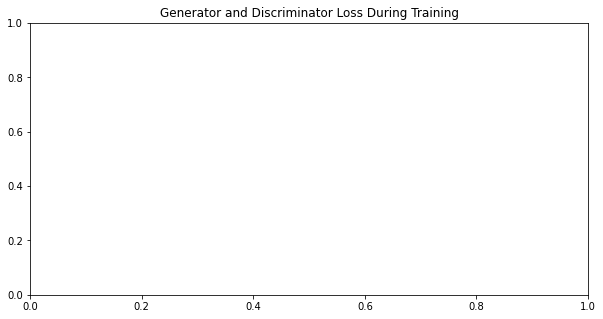

In [ ]:
# plt.figure(figsize=(10,5))
# plt.title("Generator and Discriminator Loss During Training")
# plt.plot(G_losses,label="G")
# plt.plot(D_losses,label="D")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__


